Inter-Annotator Agreement Analysis
Comparing Human vs LLM Role Annotations
This notebook calculates inter-annotator agreement between human and LLM annotations for the 'role' column.


In [20]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

In [21]:
# Load human annotations
# Adjust the file path and format as needed
try:
    human_df = pd.read_csv('../result/human/Human-annotation-test_restricted_FIXED.csv')  # Adjust path as needed
except FileNotFoundError:
    try:
        human_df = pd.read_csv('../result/human/Human-annotation-test_restricted_FIXED.csv', sep='\t')  # Try tab-separated
    except FileNotFoundError:
        print("Please check the path to human annotations file")
        # print(f"Here is the {human_df}")
        human_df = None


# Load LLM annotations
try:
    llm_df = pd.read_csv('../result/flattened-annotation/flattened_optimized_annotations.csv')
except FileNotFoundError:
    print("Please check the path to LLM annotations file")
    llm_df = None

# Display basic info about the datasets
if human_df is not None:
    print("Human Annotations:")
    print(f"Shape: {human_df.shape}")
    print(f"Columns: {list(human_df.columns)}")
    print("\nFirst few rows:")
    print(human_df.head())

if llm_df is not None:
    print("\n" + "="*50)
    print("LLM Annotations:")
    print(f"Shape: {llm_df.shape}")
    print(f"Columns: {list(llm_df.columns)}")
    print("\nFirst few rows:")
    print(llm_df.head())

Human Annotations:
Shape: (25, 9)
Columns: ['sentence', 'context_before', 'context_after', 'section', 'thesis_code', 'expression', 'role', 'justification', 'Note ']

First few rows:
                                            sentence  \
0  This thesis focuses on ‘text as an instrument’...   
1  This study takes the standpoint that genre is ...   
2  Scacci (2011) states, ‘genres exist in relatio...   
3  The present study aims to fill this gap within...   
4                 Below, Figure 1.1 visualises this:   

                                      context_before  \
0  “To a grammarian, text is a rich, many-faceted...   
1  “To a grammarian, text is a rich, many-faceted...   
2  And this study sees this corpus, the American ...   
3  Since the address is delivered on Saturdays, t...   
4  Moreover, Scacco (2011) analysed Obama’s radio...   

                                       context_after       section  \
0  The study postulates that sub-genres exist wit...  Introduction   
1  I

In [22]:
# Examine the 'role' column in both datasets
if human_df is not None and 'role' in human_df.columns:
    print("Human Role Distribution:")
    print(human_df['role'].value_counts())
    print(f"\nUnique roles in human data: {human_df['role'].unique()}")
else:
    print("role column not found in human data or data not loaded")
    print("Available columns:", list(human_df.columns) if human_df is not None else "None")

if llm_df is not None and 'role' in llm_df.columns:
    print("\n" + "="*40)
    print("LLM Role Distribution:")
    print(llm_df['role'].value_counts())
    print(f"\nUnique roles in LLM data: {llm_df['role'].unique()}")
else:
    print("\nRole column not found in LLM data or data not loaded")
    print("Available columns:", list(llm_df.columns) if llm_df is not None else "None")

Human Role Distribution:
role
Metadiscourse    14
Borderline       10
Propositional     1
Name: count, dtype: int64

Unique roles in human data: ['Metadiscourse' 'Borderline' 'Propositional']

LLM Role Distribution:
role
Metadiscourse    13
Borderline       10
Propositional     2
Name: count, dtype: int64

Unique roles in LLM data: ['Metadiscourse' 'Borderline' 'Propositional']


In [15]:
# import pandas as pd
#
# # Read the Excel file
# xlsx_file = '../result/human/Human-annotation.xlsx'  # Update with your actual path
# df = pd.read_excel(xlsx_file)
#
# # Save as CSV
# df.to_csv('../result/human/Human-annotation-test_restricted_FIXED.csv', index=False)
#
# print(f"Converted! Shape: {df.shape}")
# print(f"Columns: {list(df.columns)}")
#
# # Check if role column exists
# if 'role' in df.columns:
#     print("✓ Role column found!")
#     print(df['role'].value_counts())
# else:
#     print("Available columns:", list(df.columns))

In [32]:
# Align datasets - this assumes both datasets have some common identifier

def align_annotations(human_df, llm_df, id_column=None):
    """
    Align human and LLM annotations based on a common identifier.
    If no id_column is specified, assumes same order and length.
    """
    if human_df is None or llm_df is None:
        return None, None

    if id_column and id_column in human_df.columns and id_column in llm_df.columns:
        # Merge on common identifier
        merged = pd.merge(human_df, llm_df, on=id_column, suffixes=('_human', '_llm'))
        return merged['role_human'], merged['role_llm']
    else:
        # Assume same order and length
        min_len = min(len(human_df), len(llm_df))
        return human_df['role'][:min_len], llm_df['role'][:min_len]

# Aligning the data based on sentence (adjust id_column as needed)

human_roles, llm_roles = align_annotations(human_df, llm_df, id_column=None)

if human_roles is not None and llm_roles is not None:
    print(f"Aligned dataset size: {len(human_roles)}")
    print(f"Sample alignment check:")
    comparison_df = pd.DataFrame({
        'Human': human_roles.head(10),
        'LLM': llm_roles.head(10)
    })
    print(comparison_df)
else:
    print("Could not align the datasets. Please check data loading and column names.")

Aligned dataset size: 25
Sample alignment check:
           Human            LLM
0  Metadiscourse  Metadiscourse
1  Metadiscourse  Metadiscourse
2     Borderline     Borderline
3  Metadiscourse     Borderline
4  Metadiscourse     Borderline
5  Metadiscourse     Borderline
6  Metadiscourse  Metadiscourse
7  Metadiscourse     Borderline
8     Borderline  Metadiscourse
9     Borderline  Metadiscourse


In [34]:
def align_annotations(human_df, llm_df, id_column='sentence'):
    """
    Align human and LLM annotations based on a common identifier.
    If no id_column is specified, assumes same order and length.
    """
    if human_df is None or llm_df is None:
        return None, None, None

    if id_column and id_column in human_df.columns and id_column in llm_df.columns:
        # First, let's check how many sentences match exactly
        human_sentences = set(human_df[id_column])
        llm_sentences = set(llm_df[id_column])

        common_sentences = human_sentences.intersection(llm_sentences)
        only_human = human_sentences - llm_sentences
        only_llm = llm_sentences - human_sentences

        print(f"Sentence alignment analysis:")
        print(f"  - Total sentences in human data: {len(human_sentences)}")
        print(f"  - Total sentences in LLM data: {len(llm_sentences)}")
        print(f"  - Common sentences (exact matches): {len(common_sentences)}")
        print(f"  - Only in human data: {len(only_human)}")
        print(f"  - Only in LLM data: {len(only_llm)}")

        if len(common_sentences) == 0:
            print("\nNo exact sentence matches found. Let's check the first 10 sentences from each:")
            print("\nFirst 10 Human sentences:")
            for i, sent in enumerate(human_df[id_column].head(10)):
                print(f"  {i+1}: {sent[:100]}...")

            print("\nFirst 10 LLM sentences:")
            for i, sent in enumerate(llm_df[id_column].head(10)):
                print(f"  {i+1}: {sent[:100]}...")

            return None, None, None

        # Merge on sentence column
        merged = pd.merge(human_df, llm_df, on=id_column, suffixes=('_human', '_llm'))

        print(f"\nSuccessfully aligned {len(merged)} sentences!")

        # Show first 10 aligned sentences
        print("\nFirst 10 aligned sentences:")
        for i in range(min(10, len(merged))):
            print(f"{i+1}. Human: {merged['role_human'].iloc[i]} | LLM: {merged['role_llm'].iloc[i]}")
            print(f"   Sentence: {merged[id_column].iloc[i][:80]}...")
            print()

        return merged['role_human'], merged['role_llm'], merged
    else:
        print(f"Column '{id_column}' not found in one or both datasets")
        print("Human columns:", list(human_df.columns) if human_df is not None else "None")
        print("LLM columns:", list(llm_df.columns) if llm_df is not None else "None")

        # Fallback to positional alignment
        min_len = min(len(human_df), len(llm_df))
        return human_df['role'][:min_len], llm_df['role'][:min_len], None

# Try to align the data using sentence column
human_roles, llm_roles, merged_df = align_annotations(human_df, llm_df, id_column='sentence')

if human_roles is not None and llm_roles is not None:
    print(f"\nFinal aligned dataset size: {len(human_roles)}")

    # Create comparison DataFrame for analysis
    comparison_df = pd.DataFrame({
        'Human_Role': human_roles,
        'LLM_Role': llm_roles,
        'Agreement': human_roles == llm_roles
    })

    print(f"\nAlignment summary:")
    print(f"  - Total aligned annotations: {len(comparison_df)}")
    print(f"  - Perfect matches: {comparison_df['Agreement'].sum()}")
    print(f"  - Disagreements: {(~comparison_df['Agreement']).sum()}")
    print(f"  - Agreement rate (accuracy): {comparison_df['Agreement'].mean():.4f} ({comparison_df['Agreement'].mean()*100:.2f}%)")

else:
    print("Could not align the datasets. Please check data loading and column names.")

Sentence alignment analysis:
  - Total sentences in human data: 24
  - Total sentences in LLM data: 24
  - Common sentences (exact matches): 24
  - Only in human data: 0
  - Only in LLM data: 0

Successfully aligned 27 sentences!

First 10 aligned sentences:
1. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: This thesis focuses on ‘text as an instrument’ and aims to reveal the generic st...

2. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: This study takes the standpoint that genre is ‘a staged, goal oriented, purposef...

3. Human: Borderline | LLM: Borderline
   Sentence: Scacci (2011) states, ‘genres exist in relation to certain situational constrain...

4. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: The present study aims to fill this gap within studies of this particular genre....

5. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: Below, Figure 1.1 visualises this:...

6. Human: Metadiscourse | LLM: Metadiscourse
   Sentence: This introductory ch

In [35]:
# Calculate agreement metrics
if human_roles is not None and llm_roles is not None:
    # Remove any NaN values
    valid_indices = pd.notna(human_roles) & pd.notna(llm_roles)
    human_clean = human_roles[valid_indices]
    llm_clean = llm_roles[valid_indices]

    print(f"Valid annotations for comparison: {len(human_clean)}")

    # 1. Raw Agreement (Accuracy)
    accuracy = accuracy_score(human_clean, llm_clean)
    print(f"\n1. Raw Agreement (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")

    # 2. Cohen's Kappa
    kappa = cohen_kappa_score(human_clean, llm_clean)
    print(f"2. Cohen's Kappa: {kappa:.4f}")

    # Kappa interpretation
    if kappa < 0:
        kappa_interp = "Poor (worse than chance)"
    elif kappa < 0.2:
        kappa_interp = "Slight"
    elif kappa < 0.4:
        kappa_interp = "Fair"
    elif kappa < 0.6:
        kappa_interp = "Moderate"
    elif kappa < 0.8:
        kappa_interp = "Substantial"
    else:
        kappa_interp = "Almost Perfect"

    print(f"   Interpretation: {kappa_interp}")

    # 3. Per-class metrics
    print("\n3. Detailed Classification Report:")
    print(classification_report(human_clean, llm_clean, zero_division=0))

else:
    print("Cannot calculate metrics - data not available")

Valid annotations for comparison: 27

1. Raw Agreement (Accuracy): 0.9630 (96.30%)
2. Cohen's Kappa: 0.9302
   Interpretation: Almost Perfect

3. Detailed Classification Report:
               precision    recall  f1-score   support

   Borderline       1.00      1.00      1.00        10
Metadiscourse       1.00      0.94      0.97        16
Propositional       0.50      1.00      0.67         1

     accuracy                           0.96        27
    macro avg       0.83      0.98      0.88        27
 weighted avg       0.98      0.96      0.97        27



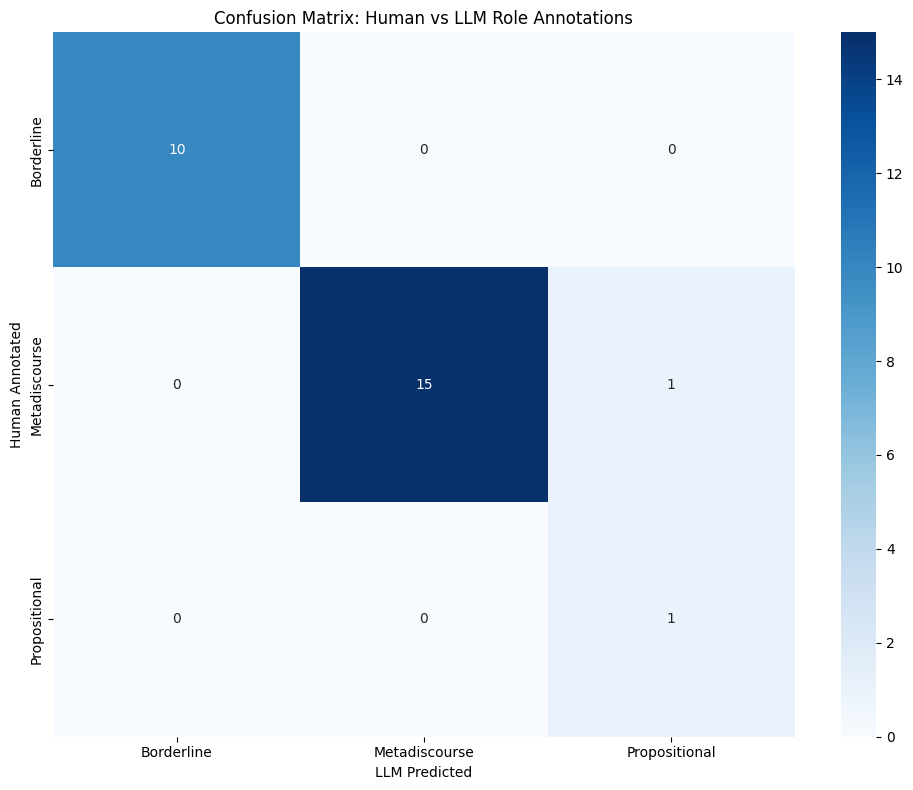

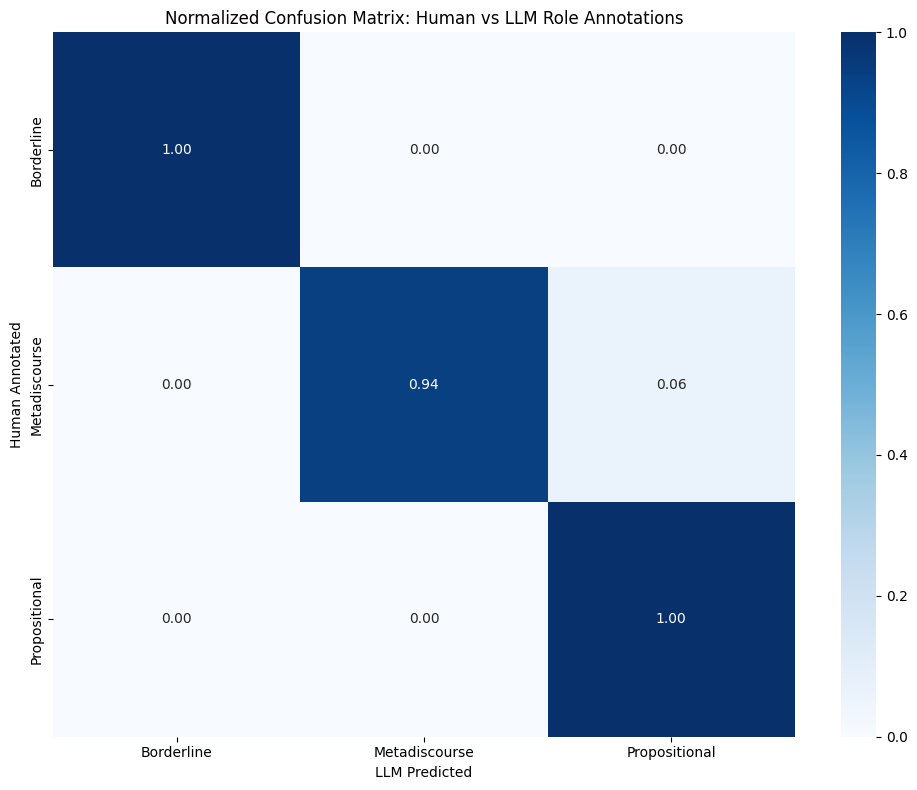

In [36]:
# Create confusion matrix and visualizations
if human_roles is not None and llm_roles is not None:
    # Confusion Matrix
    cm = confusion_matrix(human_clean, llm_clean)
    labels = sorted(list(set(human_clean) | set(llm_clean)))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix: Human vs LLM Role Annotations')
    plt.xlabel('LLM Predicted')
    plt.ylabel('Human Annotated')
    plt.tight_layout()
    plt.show()

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Normalized Confusion Matrix: Human vs LLM Role Annotations')
    plt.xlabel('LLM Predicted')
    plt.ylabel('Human Annotated')
    plt.tight_layout()
    plt.show()

Agreement rates by Human-annotated role:
               Total_Count  Agreements  Agreement_Rate
Human                                                 
Borderline              10          10          1.0000
Propositional            1           1          1.0000
Metadiscourse           16          15          0.9375


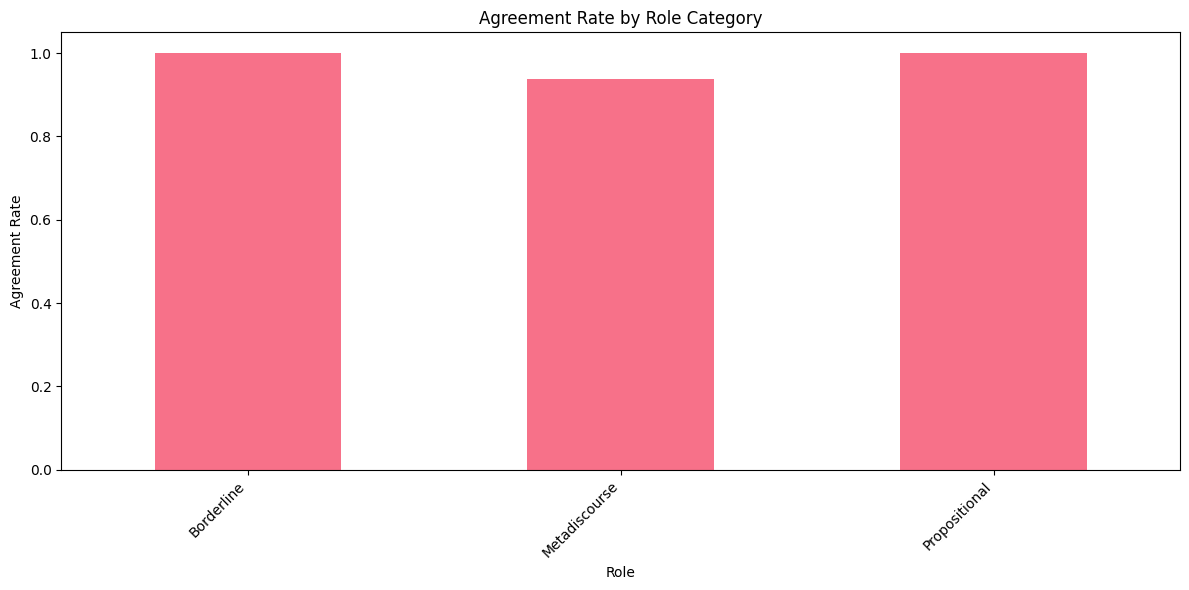


Total disagreements: 1

Most common disagreement patterns:
Human          LLM          
Metadiscourse  Propositional    1
dtype: int64


In [37]:
# Analyze agreement by role category
if human_roles is not None and llm_roles is not None:
    # Create agreement analysis by role
    agreement_df = pd.DataFrame({
        'Human': human_clean,
        'LLM': llm_clean,
        'Agreement': human_clean == llm_clean
    })

    # Agreement by human role
    role_agreement = agreement_df.groupby('Human')['Agreement'].agg(['count', 'sum', 'mean']).round(4)
    role_agreement.columns = ['Total_Count', 'Agreements', 'Agreement_Rate']

    print("Agreement rates by Human-annotated role:")
    print(role_agreement.sort_values('Agreement_Rate', ascending=False))

    # Visualize agreement rates
    plt.figure(figsize=(12, 6))
    role_agreement['Agreement_Rate'].plot(kind='bar')
    plt.title('Agreement Rate by Role Category')
    plt.xlabel('Role')
    plt.ylabel('Agreement Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Disagreement analysis
    disagreements = agreement_df[agreement_df['Agreement'] == False]
    if len(disagreements) > 0:
        print(f"\nTotal disagreements: {len(disagreements)}")
        print("\nMost common disagreement patterns:")
        disagreement_patterns = disagreements.groupby(['Human', 'LLM']).size().sort_values(ascending=False)
        print(disagreement_patterns.head(10))
    else:
        print("\nNo disagreements found - perfect agreement!")

In [38]:
# Test statistical significance of agreement
if human_roles is not None and llm_roles is not None:
    # Chi-square test for independence
    chi2, p_value, dof, expected = chi2_contingency(cm)

    print(f"Chi-square test for independence:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4e}")
    print(f"Degrees of freedom: {dof}")

    if p_value < 0.05:
        print("Result: Significant association between human and LLM annotations (p < 0.05)")
    else:
        print("Result: No significant association between human and LLM annotations (p >= 0.05)")

    # Calculate expected agreement by chance
    human_dist = pd.Series(human_clean).value_counts(normalize=True)
    llm_dist = pd.Series(llm_clean).value_counts(normalize=True)

    chance_agreement = sum(human_dist.get(role, 0) * llm_dist.get(role, 0)
                          for role in set(human_clean) | set(llm_clean))

    print(f"\nExpected agreement by chance: {chance_agreement:.4f} ({chance_agreement*100:.2f}%)")
    print(f"Observed agreement: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Improvement over chance: {(accuracy - chance_agreement):.4f} ({(accuracy - chance_agreement)*100:.2f} percentage points)")

Chi-square test for independence:
Chi-square statistic: 39.6562
p-value: 5.0981e-08
Degrees of freedom: 4
Result: Significant association between human and LLM annotations (p < 0.05)

Expected agreement by chance: 0.4691 (46.91%)
Observed agreement: 0.9630 (96.30%)
Improvement over chance: 0.4938 (49.38 percentage points)


In [42]:
# Generate summary report
if human_roles is not None and llm_roles is not None:
    print("=" * 60)
    print("INTER-ANNOTATOR AGREEMENT SUMMARY REPORT")
    print("=" * 60)

    print(f"Dataset Information:")
    print(f"  - Total aligned annotations: {len(human_clean)}")
    print(f"  - Unique roles in human data: {len(human_clean.unique())}")
    print(f"  - Unique roles in LLM data: {len(llm_clean.unique())}")

    print(f"\nAgreement Metrics:")
    print(f"  - Raw Agreement (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  - Cohen's Kappa: {kappa:.4f} ({kappa_interp})")
    print(f"  - Agreement over chance: +{(accuracy - chance_agreement)*100:.2f} percentage points")

    if len(disagreements) > 0:
        print(f"\nDisagreement Analysis:")
        print(f"  - Total disagreements: {len(disagreements)}")
        print(f"  - Disagreement rate: {(1-accuracy)*100:.2f}%")

    print(f"\nStatistical Significance:")
    if p_value < 0.05:
        print(f"  - Significant association found (p < 0.05)")
    else:
        print(f"  - No significant association (p >= 0.05)")

    print(f"\nRecommendations:")
    if kappa > 0.6:
        print(f"  - Agreement is substantial/strong. LLM annotations are reliable.")
    elif kappa > 0.4:
        print(f"  - Agreement is moderate. Consider reviewing disagreement patterns.")
    else:
        print(f"  - Agreement is low. LLM may need retraining or prompt refinement.")

    print("=" * 60)
else:
    print("Cannot generate summary - data not loaded properly.")
    print("Please check file paths and formats in the data loading section.")

INTER-ANNOTATOR AGREEMENT SUMMARY REPORT
Dataset Information:
  - Total aligned annotations: 27
  - Unique roles in human data: 3
  - Unique roles in LLM data: 3

Agreement Metrics:
  - Raw Agreement (Accuracy): 0.9630 (96.30%)
  - Cohen's Kappa: 0.9302 (Almost Perfect)
  - Agreement over chance: +49.38 percentage points

Disagreement Analysis:
  - Total disagreements: 1
  - Disagreement rate: 3.70%

Statistical Significance:
  - Significant association found (p < 0.05)

Recommendations:
  - Agreement is substantial/strong. LLM annotations are reliable.


In [43]:
# Export detailed results to CSV
if human_roles is not None and llm_roles is not None:
    # Create detailed comparison dataframe
    results_df = pd.DataFrame({
        'Human_Role': human_clean,
        'LLM_Role': llm_clean,
        'Agreement': human_clean == llm_clean
    })

    # Add index for reference
    results_df['Index'] = range(len(results_df))

    # Save results
    results_df.to_csv('agreement_analysis_results.csv', index=False)
    print("Detailed results saved to 'agreement_analysis_results.csv'")

    # Save summary metrics
    summary_metrics = {
        'Metric': ['Raw_Agreement', 'Cohens_Kappa', 'Total_Samples', 'Disagreements', 'Chi_Square_p_value'],
        'Value': [accuracy, kappa, len(human_clean), len(disagreements), p_value]
    }

    summary_df = pd.DataFrame(summary_metrics)
    summary_df.to_csv('agreement_summary_metrics.csv', index=False)
    print("Summary metrics saved to 'agreement_summary_metrics.csv'")

    print("\nAnalysis complete!")
else:
    print("Cannot export results - data not loaded properly.")

Detailed results saved to 'agreement_analysis_results.csv'
Summary metrics saved to 'agreement_summary_metrics.csv'

Analysis complete!
